<a href="https://colab.research.google.com/github/herysedra/covid19-mankaiza-clone/blob/andrana/scripts/paper/simple_blocks/change_point_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5


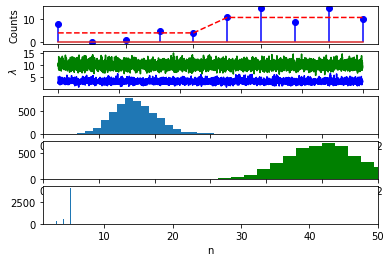

In [15]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

from scipy.stats import uniform, gamma, poisson

# fix the random seed for replicability.
np.random.seed(123456789)

# Generate data

# Hyperparameters
N=10
a=2
b=1

# Change-point: where the intensity parameter changes.
n=int(round(uniform.rvs()*N))
print(str(n))

# Intensity values
lambda1=gamma.rvs(a,1/b) # We use 1/b instead of b because of the way Gamma distribution is parametrized in the package random.
lambda2=gamma.rvs(a,1/b)

lambdas=[lambda1]*n
lambdas[n:N-1]=[lambda2]*(N-n)

# Observations, x_1 ... x_N
x=poisson.rvs(lambdas)

# make one big subplots and put everything in it.
f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1)
# Plot the data
ax1.stem(range(N),x,linefmt='b-', markerfmt='bo',use_line_collection=True)
ax1.plot(range(N),lambdas,'r--')
ax1.set_ylabel('Counts')

# Gibbs sampler
E=5200
BURN_IN=200

# Initialize the chain
n=int(round(uniform.rvs()*N))
lambda1=gamma.rvs(a,scale=1./b)
lambda2=gamma.rvs(a,scale=1./b)

# Store the samples
chain_n=np.array([0.]*(E-BURN_IN))
chain_lambda1=np.array([0.]*(E-BURN_IN))
chain_lambda2=np.array([0.]*(E-BURN_IN))

for e in range(E):
	# print("At iteration", str(e))
	# sample lambda1 and lambda2 from their posterior conditionals, Equation 8 and Equation 9, respectively.
	lambda1=gamma.rvs(a+sum(x[0:n]), scale=1/(n+b))
	lambda2=gamma.rvs(a+sum(x[n:N]), scale=1/(N-n+b))
	
	# sample n, Equation 10
	mult_n=np.array([0]*N)
	for i in range(N):
		mult_n[i]=sum(x[0:i])*np.log(lambda1)-i*lambda1+sum(x[i:N])*np.log(lambda2)-(N-i)*lambda2
	mult_n=np.exp(mult_n-max(mult_n))
	n=np.where(np.random.multinomial(1,mult_n/sum(mult_n),size=1)==1)[1][0]
	
	# store
	if e>=BURN_IN:
		chain_n[e-BURN_IN]=n
		chain_lambda1[e-BURN_IN]=lambda1
		chain_lambda2[e-BURN_IN]=lambda2
		

ax2.plot(chain_lambda1,'b',chain_lambda2,'g')
ax2.set_ylabel('$\lambda$')
ax3.hist(chain_lambda1,20)
ax3.set_xlabel('$\lambda_1$')
ax3.set_xlim([0,12])
ax4.hist(chain_lambda2,20,color='g')
ax4.set_xlim([0,12])
ax4.set_xlabel('$\lambda_2$')
ax5.hist(chain_n,50)
ax5.set_xlabel('n')
ax5.set_xlim([1,50])
plt.show()